# Our code for Task B -> CSE440 SEXISM CATEGORIZATION

In [ ]:
import numpy as np
import pandas as pd
import re, string
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import nltk
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.ticker as ticker
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE

In [ ]:
df = pd.read_csv ('/content/drive/MyDrive/BracU/CSE440/train_all_tasks.csv')
df.head ()

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none


In [ ]:
print( f'Dataset description:\n {df.describe ()}' )

print( f'Unique catagory:\r\n {df ["label_category"].value_counts()}\n')

print( df.isnull().sum() )
print('\nRows with null values in text column: ', df['text'].isnull().sum())
print('Rows with null values in label_category column: ', df['label_category'].isnull().sum())

duplicate = df.duplicated('text')
print("How many duplicate texts are there: \n", duplicate.value_counts())

Dataset description:
                       rewire_id                                   text  \
count                     14000                                  14000   
unique                    14000                                  14000   
top     sexism2022_english-7358  Damn, this writing was pretty chaotic   
freq                          1                                      1   

       label_sexist label_category label_vector  
count         14000          14000        14000  
unique            2              5           12  
top      not sexist           none         none  
freq          10602          10602        10602  
Unique catagory:
 label_category
none                                        10602
2. derogation                                1590
3. animosity                                 1165
4. prejudiced discussions                     333
1. threats, plans to harm and incitement      310
Name: count, dtype: int64

rewire_id         0
text              0
label_s

Text(0.5, 1.0, 'The distribution of Sexism category of the data')

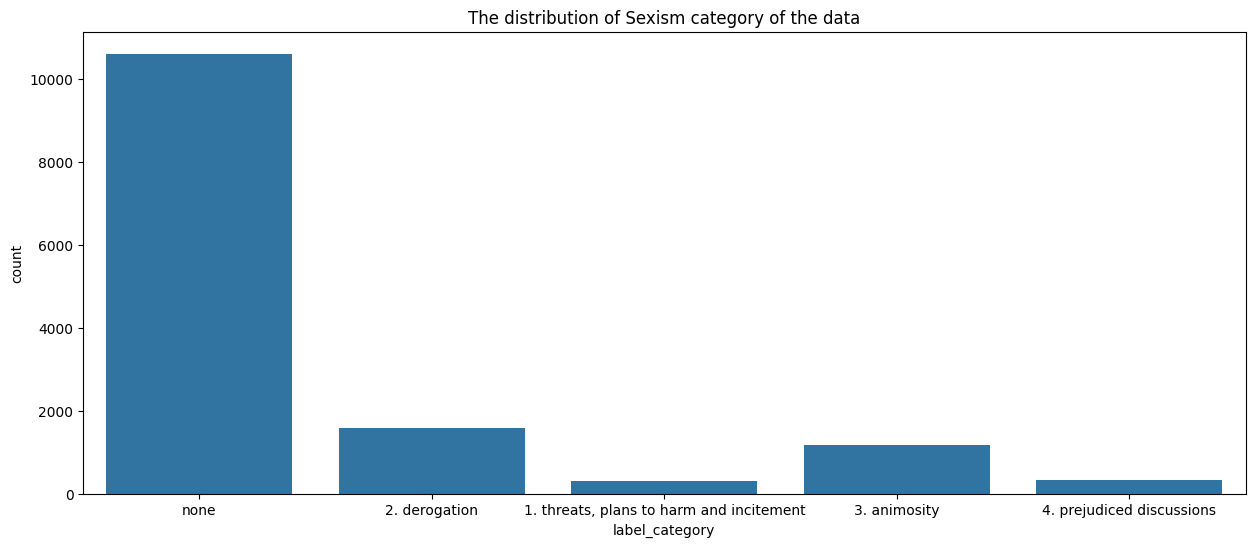

In [ ]:
plt.figure(figsize=(15,6))
sns.countplot(x="label_category",data=df)
plt.title('The distribution of Sexism category of the data')

In [ ]:
def processData():
    processed = re.compile('<.*?>')

    df['text'] = df['text'].apply(lambda x: x.lower())
    df['text'] = df['text'].apply((lambda x: re.sub(processed, ' ', x)))
    df['text'] = df['text'].apply((lambda x: re.sub('https://.*', ' ', x)))
processData()


def drop_column(columns):
    global df
    df = df.drop(columns, axis = 1)

def drop_rows(columns):
    global df
    df = df.dropna(axis = 0, subset = columns)


drop = ['rewire_id']
drop_column(drop)

print( f'\nShape of the dataset is now: {df.shape}\n' )
df.tail()


Shape of the dataset is now: (14000, 4)



,text,label_sexist,label_category,label_vector
13995,complexes like the 'nice chicks' that go after...,sexist,2. derogation,2.1 descriptive attacks
13996,"""graphic germany - muslim ""refugee"" stabbing h...",not sexist,none,none
13997,lol i imagine there would be simps that are li...,not sexist,none,none
13998,"it's not, the girls i go on dates with don't k...",not sexist,none,none
13999,how can he be an incel? he does have a girlfri...,not sexist,none,none


In [ ]:
label_num = {
    'none': 0,
    '1. threats, plans to harm and incitement': 1,
    '2. derogation': 2,
    '3. animosity': 3,
    '4. prejudiced discussions': 4,
    }

df['category_sexism'] = df['label_category'].map(label_num)

df.head()

,text,label_sexist,label_category,label_vector,category_sexism
0,"damn, this writing was pretty chaotic",not sexist,none,none,0
1,"yeah, and apparently a bunch of misogynistic v...",not sexist,none,none,0
2,how the fuck is this woman still an mp!!!???,not sexist,none,none,0
3,understand. know you're right. at same time i ...,not sexist,none,none,0
4,surprized they didn't stop and rape some women,not sexist,none,none,0


<ipython-input-8-5525471bc21a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, x='category_sexism', y='label_sexist', inner='box', palette='Dark2')


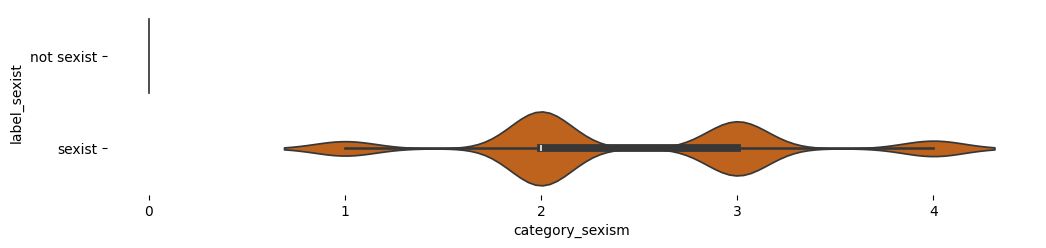

In [ ]:
# @title label_sexist vs category_sexism

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df['label_sexist'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df, x='category_sexism', y='label_sexist', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
#Train-valdation-test split
x = df['text']
y = df['category_sexism']

x_train, x_hold, y_train, y_hold = train_test_split (x, y, random_state = 42, test_size = 0.20, shuffle=True, stratify=y)
x_test, x_val, y_test, y_val = train_test_split (x_hold, y_hold, test_size = 0.50, random_state = 42, shuffle= True, stratify = y_hold)


print ( "Training Data size: x_train {}  y_train {}".format( x_train.shape, y_train.shape ), ' - {}%'.format( ( len(x_train) / len(y) ) * 100 ) )
print ( "Validation Data size: x_val {}, y_val {}".format( x_val.shape, y_val.shape ), ' - {}%'.format( ( len(x_val) / len(y) ) * 100 ) )
print ( "Testing Data size: x_test {}  y_test {}".format( x_test.shape, y_test.shape ), ' - {}%\n'.format( ( len(x_test) / len(y) ) * 100 ) )

print( 'y_train unique values counts:\n{}\n'.format( y_train.value_counts() ) )
print( 'y_val unique values counts:\n{}\n'.format( y_val.value_counts() ) )
print( 'y_test unique values counts:\n{}\n'.format( y_test.value_counts() ) )


Training Data size: x_train (11200,)  y_train (11200,)  - 80.0%
Validation Data size: x_val (1400,), y_val (1400,)  - 10.0%
Testing Data size: x_test (1400,)  y_test (1400,)  - 10.0%

y_train unique values counts:
category_sexism
0    8482
2    1272
3     932
4     266
1     248
Name: count, dtype: int64

y_val unique values counts:
category_sexism
0    1060
2     159
3     117
4      33
1      31
Name: count, dtype: int64

y_test unique values counts:
category_sexism
0    1060
2     159
3     116
4      34
1      31
Name: count, dtype: int64



In [ ]:
num_words = 2500
import random
randint = random.randint(1,2000)

print( f"Random X-train value index {randint} (before tokenization): ", x_train[randint] )

tokenizer = Tokenizer (num_words = num_words, lower = False)


def tokenization( x_train, x_val, x_test ):

  tokenizer.fit_on_texts (x_train)

  tokenized_xtrain = tokenizer.texts_to_sequences (x_train)
  tokenized_xval = tokenizer.texts_to_sequences (x_val)
  tokenized_xtest = tokenizer.texts_to_sequences (x_test)

  return tokenized_xtrain, tokenized_xval, tokenized_xtest

x_train, x_val, x_test = tokenization (x_train, x_val, x_test)


vocab = tokenizer.word_index
vocab_size = len( tokenizer.word_index ) + 1


print( "\n", vocab )
print( "\nThe size of Vocabulary: ", vocab_size )

# print( "\nX-train value: {}\n".format( x_train ) )
print( f"\nX-train value index {randint} (after tokenization): ", x_train[randint] )
print( f"Y-train value index {randint}: ", y_train[randint] )

Random X-train value index 613 (before tokenization):  navarro is about as much an attorney as she is a republican. 😂😆

 {'the': 1, 'a': 2, 'to': 3, 'and': 4, 'i': 5, 'you': 6, 'of': 7, 'is': 8, 'her': 9, 'that': 10, 'in': 11, 'she': 12, 'women': 13, 'it': 14, 'for': 15, 'are': 16, 'with': 17, 'this': 18, 'be': 19, 'on': 20, 'they': 21, 'not': 22, 'have': 23, 'if': 24, 'url': 25, 'but': 26, 'just': 27, 'like': 28, 'as': 29, 'your': 30, 'was': 31, 'my': 32, 'all': 33, 'so': 34, 'or': 35, 'what': 36, 'do': 37, 'woman': 38, 'me': 39, 'who': 40, 'get': 41, 'he': 42, 'about': 43, 'out': 44, 'no': 45, 'at': 46, 'up': 47, 'men': 48, "don't": 49, 'can': 50, 'will': 51, 'their': 52, 'would': 53, 'them': 54, 'user': 55, 'how': 56, 'an': 57, "it's": 58, 'by': 59, 'we': 60, 'when': 61, 'because': 62, 'one': 63, 'has': 64, 'girl': 65, 'from': 66, 'girls': 67, 'his': 68, 'fuck': 69, 'more': 70, 'want': 71, 'white': 72, 'female': 73, 'why': 74, 'shit': 75, 'think': 76, "i'm": 77, 'know': 78, 'people'

In [ ]:
def padding (x_train, x_val, x_test):
    maxlen = 50

    padded_xtrain = pad_sequences( x_train, padding = 'post', maxlen = maxlen )
    padded_xval = pad_sequences( x_val, padding = 'post', maxlen = maxlen )
    padded_xtest = pad_sequences( x_test, padding = 'post', maxlen = maxlen )

    return maxlen, padded_xtrain, padded_xval, padded_xtest

maxlen, x_train, x_val, x_test = padding( x_train, x_val, x_test )


print("max length of each padded texts: ", maxlen)

print( "\n[ x_train.shape[0], x_train.shape[1] ]: [ {}, {} ]".format ( x_train.shape[0], x_train.shape[1] ) )
print( "\n[ x_val.shape[0], x_val.shape[1] ]: [ {}, {} ]".format ( x_val.shape[0], x_val.shape[1] ) )
print( "\n[ x_test.shape[0], x_test.shape[1] ]: [ {}, {} ]\n".format ( x_test.shape[0], x_test.shape[1] ) )

print( "X-train row index 3:\n", x_train[3, :] )


max length of each padded texts:  50

[ x_train.shape[0], x_train.shape[1] ]: [ 11200, 50 ]

[ x_val.shape[0], x_val.shape[1] ]: [ 1400, 50 ]

[ x_test.shape[0], x_test.shape[1] ]: [ 1400, 50 ]

X-train row index 3:
 [ 573 1957   27    2   13   17    2  294  460    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [ ]:
from keras.utils import to_categorical
num_classes = 5

y_train = to_categorical (y_train - 1, num_classes)
y_val = to_categorical (y_val - 1, num_classes)
y_test = to_categorical (y_test - 1, num_classes)

print("\ny_train shape:", y_train.shape)
print("y_train index 0:", y_train[0])

print( '\n( shape of x_train, shape of y_train ): ( {}, {} )'.format( x_train.shape, y_train.shape ) )
print( '( shape of x_val, shape of y_val ): ( {}, {} )'.format( x_val.shape, y_val.shape ) )
print( '( shape of x_test, shape of y_test ): ( {}, {} )\n'.format( x_test.shape, y_test.shape ) )


y_train shape: (11200, 5)
y_train index 0: [0. 1. 0. 0. 0.]

( shape of x_train, shape of y_train ): ( (11200, 50), (11200, 5) )
( shape of x_val, shape of y_val ): ( (1400, 50), (1400, 5) )
( shape of x_test, shape of y_test ): ( (1400, 50), (1400, 5) )



In [ ]:
#func to create embedding_matrix tdhrough GloVe embeding
def create_embedding_matrix(filepath, word_index, embedding_dim):

    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix


embedding_dim = 100
embedding_matrix = create_embedding_matrix( '/content/drive/MyDrive/BracU/CSE440/glove.6B.100d.txt', tokenizer.word_index, embedding_dim )

print("The embedding matrix with GLoVe embedding: \n", embedding_matrix)

nonzero_elements = np.count_nonzero( np.count_nonzero(embedding_matrix, axis=1) )
print( "Amount of nonzero embedding vectors: ", nonzero_elements / vocab_size )

The embedding matrix with GLoVe embedding: 
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.038194   -0.24487001  0.72812003 ... -0.1459      0.82779998
   0.27061999]
 [-0.27085999  0.044006   -0.02026    ... -0.4923      0.63687003
   0.23642001]
 ...
 [ 0.17428    -0.40492001  0.54396999 ... -0.39197999  0.12698001
  -0.65447998]
 [ 0.045521   -0.28689     0.23307    ... -0.041397   -0.52139997
  -0.024642  ]
 [ 0.40079001 -0.57675999  0.06379    ...  0.33825001 -0.037264
  -0.050584  ]]
Amount of nonzero embedding vectors:  0.7995108804152525


In [ ]:
# Define parameter
n_lstm = 128
drop_lstm = 0.2
# Define LSTM Model
model1 = Sequential()
model1.add( layers.Embedding( vocab_size, embedding_dim, weights = [embedding_matrix], input_length = maxlen, trainable = True ) )
model1.add( layers.LSTM ( n_lstm, dropout = drop_lstm ) )
model1.add( layers.Dense ( 5, activation ='sigmoid' ) )
model1.compile ( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'] )
print ( model1.summary() )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 100)           2003600   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 5)                 645       
                                                                 
Total params: 2121493 (8.09 MB)
Trainable params: 2121493 (8.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
batch_size = 32
num_epochs = 20

history = model1.fit( x_train, y_train, epochs = num_epochs, verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size)

Epoch 1/20
350/350 [==============================] - 40s 107ms/step - loss: 0.8624 - accuracy: 0.7564 - val_loss: 0.8453 - val_accuracy: 0.7571
Epoch 2/20
350/350 [==============================] - 40s 115ms/step - loss: 0.8388 - accuracy: 0.7573 - val_loss: 0.8453 - val_accuracy: 0.7571
Epoch 3/20
350/350 [==============================] - 38s 109ms/step - loss: 0.7931 - accuracy: 0.7585 - val_loss: 0.7143 - val_accuracy: 0.7693
Epoch 4/20
350/350 [==============================] - 41s 117ms/step - loss: 0.6626 - accuracy: 0.7843 - val_loss: 0.6667 - val_accuracy: 0.7843
Epoch 5/20
350/350 [==============================] - 40s 114ms/step - loss: 0.6106 - accuracy: 0.7959 - val_loss: 0.6523 - val_accuracy: 0.7807
Epoch 6/20
350/350 [==============================] - 39s 113ms/step - loss: 0.5808 - accuracy: 0.8033 - val_loss: 0.6568 - val_accuracy: 0.7836
Epoch 7/20
350/350 [==============================] - 42s 120ms/step - loss: 0.5529 - accuracy: 0.8100 - val_loss: 0.6601 - val_ac

In [ ]:
loss, accuracy = model1.evaluate( x_train, y_train, verbose = False )
print( "\nTraining Accuracy: {:.4f}, Training Loss: {:.4f}".format(accuracy, loss) )

loss, accuracy = model1.evaluate( x_test, y_test, verbose = False )
print( "Testing Accuracy:  {:.4f}, Testing Loss: {:.4f}\n".format(accuracy, loss) )


Training Accuracy: 0.9439, Training Loss: 0.1743
Testing Accuracy:  0.7529, Testing Loss: 1.0033



In [ ]:
# Hyperperameter tuned
def lstm_hypertuned (dense, maxlen):
    lstm_out = 128

    model = Sequential()

    model.add( layers.Embedding( vocab_size, embedding_dim, weights = [embedding_matrix], input_length = maxlen, trainable = True ) )
    model.add ( layers.SpatialDropout1D (0.4) )
    model.add( layers.LSTM ( lstm_out, dropout = 0.2, recurrent_dropout = 0.2, activation = 'tanh' ) )
    model.add( layers.Dense( 50, activation='relu' ) )
    model.add( layers.Dense ( dense, activation ='sigmoid' ) )

    model.compile ( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'] )
    print ( model.summary() )

    return model

model2 = lstm_hypertuned (5, maxlen)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 100)           2003600   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 50)                6450      
                                                                 
 dense_2 (Dense)             (None, 5)                 255       
                                                                 
Total params: 2127553 (8.12 MB)
Trainable params: 2127553 (8.12 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
batch_size = 64
history2 = model2.fit( x_train, y_train, epochs = 20, verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

Epoch 1/20
175/175 [==============================] - 39s 208ms/step - loss: 0.8795 - accuracy: 0.7535 - val_loss: 0.8422 - val_accuracy: 0.7571
Epoch 2/20
175/175 [==============================] - 38s 220ms/step - loss: 0.8425 - accuracy: 0.7573 - val_loss: 0.8348 - val_accuracy: 0.7571
Epoch 3/20
175/175 [==============================] - 36s 206ms/step - loss: 0.8304 - accuracy: 0.7573 - val_loss: 0.8142 - val_accuracy: 0.7571
Epoch 4/20
175/175 [==============================] - 37s 210ms/step - loss: 0.7564 - accuracy: 0.7579 - val_loss: 0.7257 - val_accuracy: 0.7593
Epoch 5/20
175/175 [==============================] - 38s 215ms/step - loss: 0.6823 - accuracy: 0.7829 - val_loss: 0.6652 - val_accuracy: 0.7843
Epoch 6/20
175/175 [==============================] - 36s 205ms/step - loss: 0.6476 - accuracy: 0.7863 - val_loss: 0.6528 - val_accuracy: 0.7779
Epoch 7/20
175/175 [==============================] - 37s 214ms/step - loss: 0.6287 - accuracy: 0.7930 - val_loss: 0.6433 - val_ac

In [ ]:
loss, accuracy = model2.evaluate( x_train, y_train, verbose = False )
print( "\nTraining Accuracy: {:.2f}, Training Loss: {:.2f}".format(accuracy, loss) )

losstest, accuracytest = model2.evaluate( x_test, y_test, verbose = False )
print( "Testing Accuracy:  {:.2f}, Testing Loss: {:.2f}\n".format(accuracytest, losstest) )

bestcate_lstm_accloss = [loss, accuracy, losstest, accuracytest, history2]



Training Accuracy: 0.85, Training Loss: 0.42
Testing Accuracy:  0.78, Testing Loss: 0.71



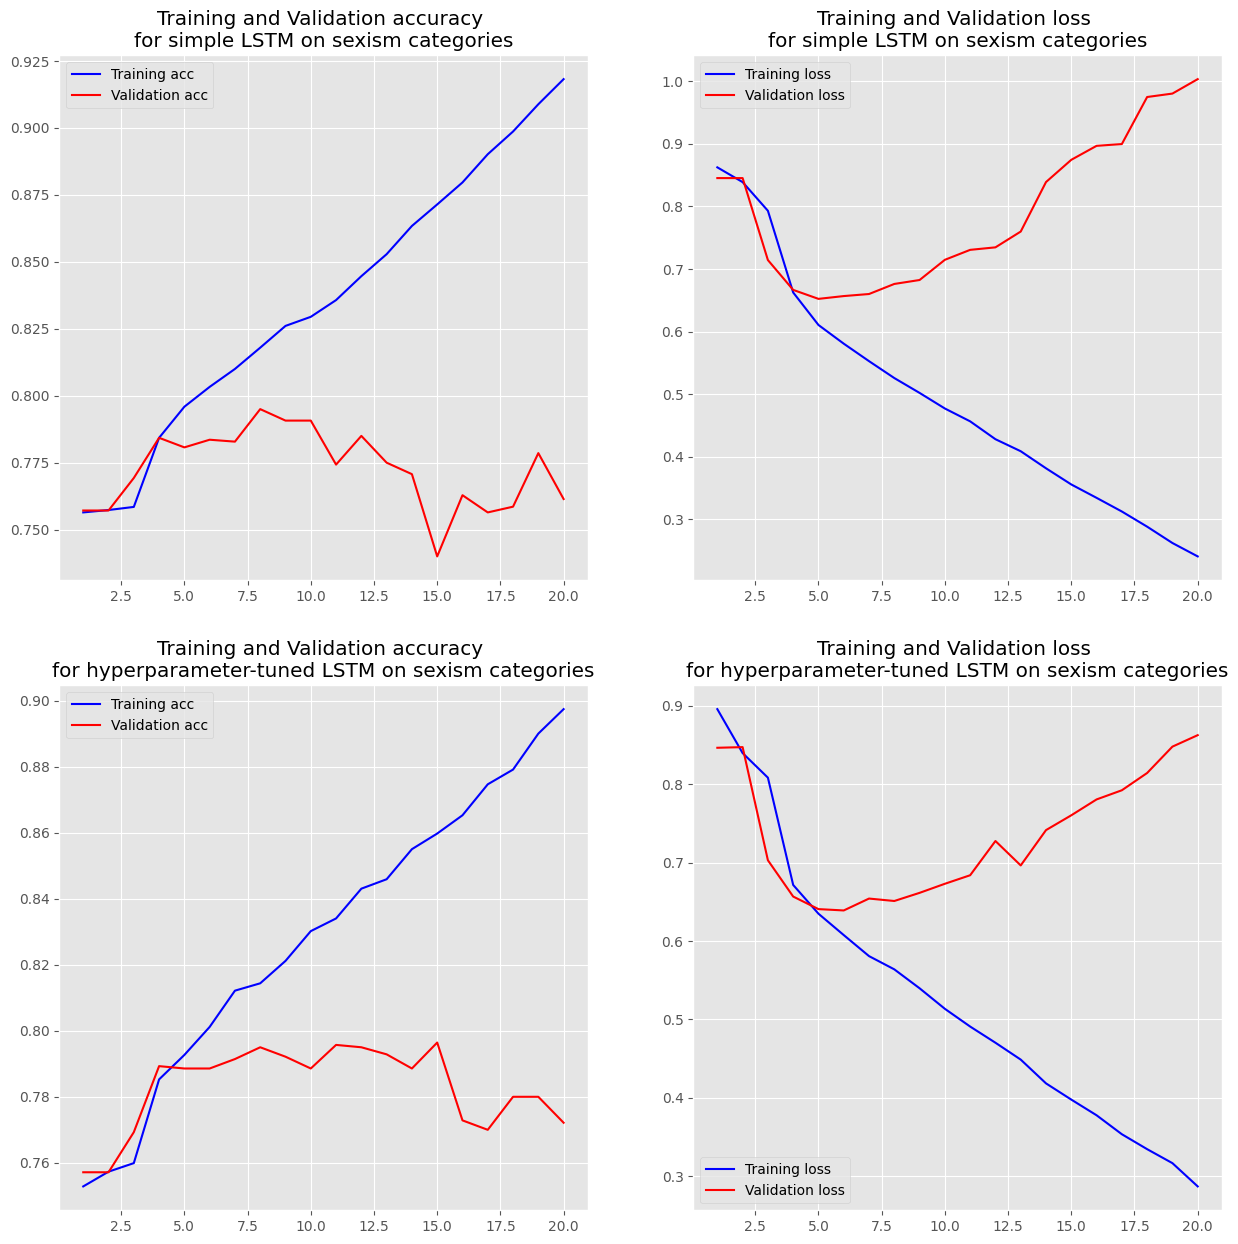

In [ ]:
plt.style.use('ggplot')

def plot_history(history1, history2, m, n):

    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    x = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 15))

    plt.subplot(2, 2, 1)
    plt.plot(x, acc, 'blue', label = 'Training acc')
    plt.plot(x, val_acc, 'red', label = 'Validation acc')
    plt.title('Training and Validation accuracy \nfor {}'.format(m))
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(x, loss, 'blue', label = 'Training loss')
    plt.plot(x, val_loss, 'red', label = 'Validation loss')
    plt.title('Training and Validation loss \nfor {}'.format(m))
    plt.legend()


    acc = history2.history['accuracy']
    val_acc = history2.history['val_accuracy']
    loss = history2.history['loss']
    val_loss = history2.history['val_loss']

    plt.subplot(2, 2, 3)
    plt.plot(x, acc, 'blue', label = 'Training acc')
    plt.plot(x, val_acc, 'red', label = 'Validation acc')
    plt.title('Training and Validation accuracy \nfor {}'.format(n))
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(x, loss, 'blue', label = 'Training loss')
    plt.plot(x, val_loss, 'red', label = 'Validation loss')
    plt.title('Training and Validation loss \nfor {}'.format(n))
    plt.legend()

plot_history(history, history3, "simple LSTM on sexism categories", "hyperparameter-tuned LSTM on sexism categories")

In [ ]:
# Hyperperameter tuned GRU model

def gru_hypertuned (dense, maxlen):
    gru_out = 128

    model = Sequential()

    model.add( layers.Embedding( vocab_size, embedding_dim, weights = [embedding_matrix], input_length = maxlen, trainable = True ) )
    model.add ( layers.SpatialDropout1D (0.2) )
    model.add( layers.GRU ( gru_out, dropout = 0.2, return_sequences = False ) )
    model.add( layers.Dense( 50, activation='relu' ) )
    model.add( layers.Dense ( dense, activation ='sigmoid' ) )

    model.compile ( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'] )
    print ( model.summary() )

    return model

model3 = gru_hypertuned (5, maxlen)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 100)           2003600   
                                                                 
 spatial_dropout1d_2 (Spati  (None, 50, 100)           0         
 alDropout1D)                                                    
                                                                 
 gru_1 (GRU)                 (None, 128)               88320     
                                                                 
 dense_5 (Dense)             (None, 50)                6450      
                                                                 
 dense_6 (Dense)             (None, 5)                 255       
                                                                 
Total params: 2098625 (8.01 MB)
Trainable params: 2098625 (8.01 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
batch_size = 64
history3 = model3.fit( x_train, y_train, epochs = 20, verbose = True, validation_data = ( x_val, y_val ), batch_size = batch_size )

Epoch 1/20
175/175 [==============================] - 27s 141ms/step - loss: 0.9017 - accuracy: 0.7535 - val_loss: 0.8432 - val_accuracy: 0.7571
Epoch 2/20
175/175 [==============================] - 23s 133ms/step - loss: 0.8425 - accuracy: 0.7574 - val_loss: 0.8477 - val_accuracy: 0.7571
Epoch 3/20
175/175 [==============================] - 26s 151ms/step - loss: 0.8160 - accuracy: 0.7578 - val_loss: 0.7032 - val_accuracy: 0.7807
Epoch 4/20
175/175 [==============================] - 23s 131ms/step - loss: 0.6757 - accuracy: 0.7854 - val_loss: 0.6728 - val_accuracy: 0.7829
Epoch 5/20
175/175 [==============================] - 25s 142ms/step - loss: 0.6284 - accuracy: 0.7938 - val_loss: 0.6417 - val_accuracy: 0.7936
Epoch 6/20
175/175 [==============================] - 25s 144ms/step - loss: 0.6060 - accuracy: 0.8007 - val_loss: 0.6460 - val_accuracy: 0.7886
Epoch 7/20
175/175 [==============================] - 25s 146ms/step - loss: 0.5797 - accuracy: 0.8081 - val_loss: 0.6540 - val_ac

In [ ]:
loss, accuracy = model3.evaluate( x_train, y_train, verbose = False )
print( "\nTraining Accuracy: {:.2f}, Training Loss: {:.2f}".format(accuracy, loss) )

losstest, accuracytest = model3.evaluate( x_test, y_test, verbose = False )
print( "Testing Accuracy:  {:.2f}, Testing Loss: {:.2f}\n".format(accuracytest, losstest) )

gru_accloss = [loss, accuracy, losstest, accuracytest, history3]


Training Accuracy: 0.95, Training Loss: 0.17
Testing Accuracy:  0.75, Testing Loss: 0.97



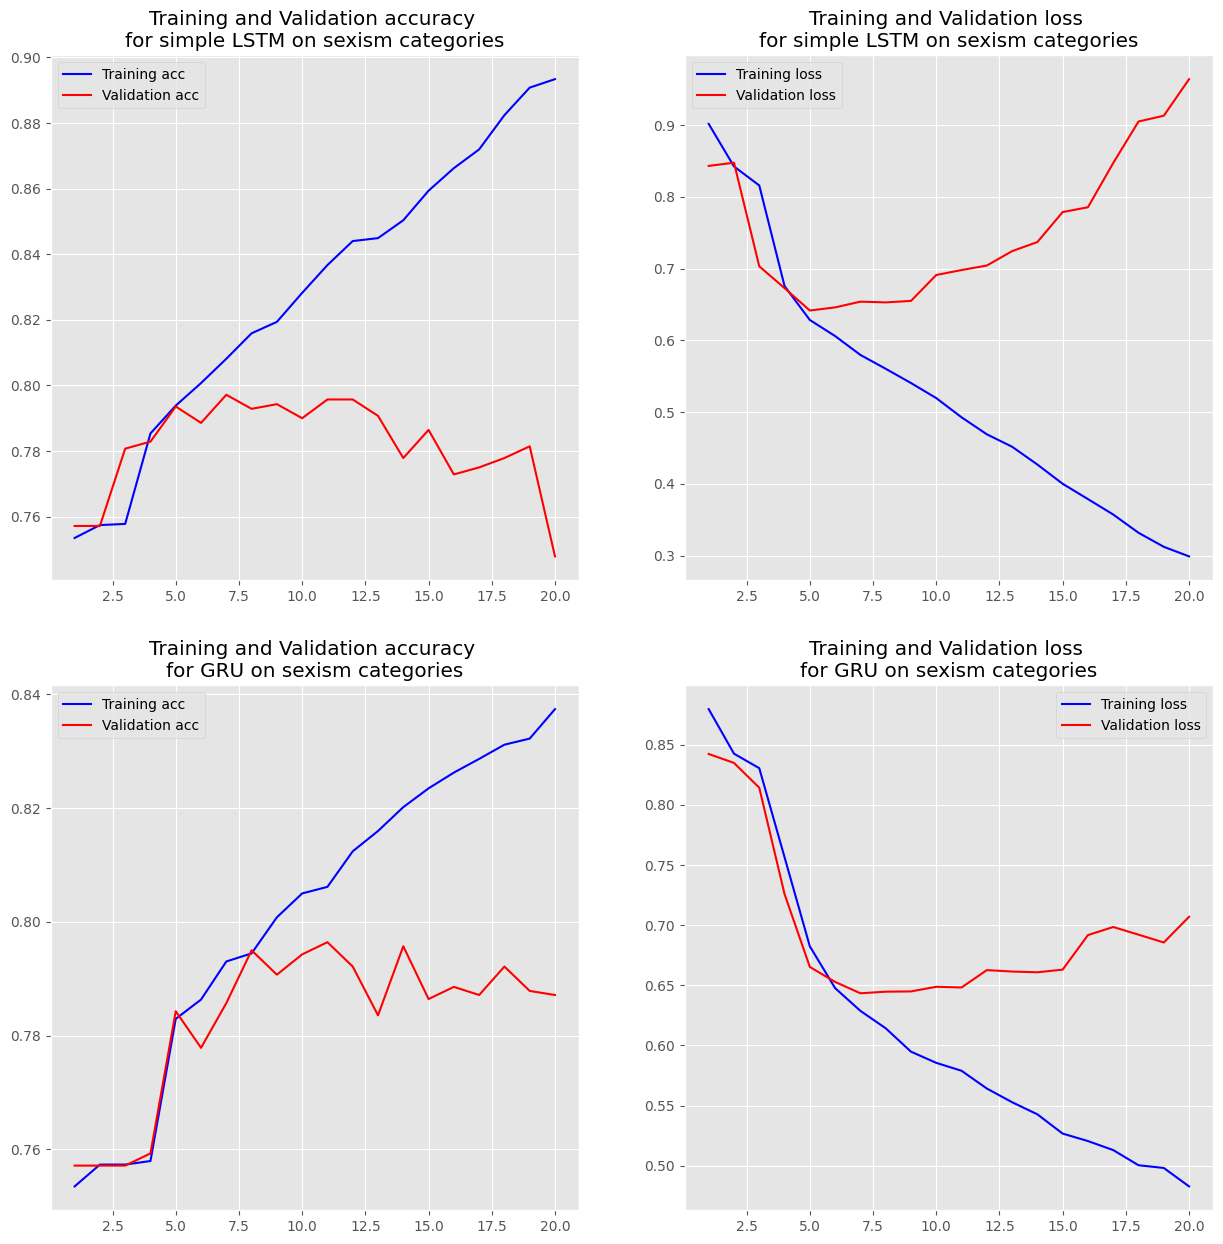

In [ ]:
plt.style.use('ggplot')

def plot_history(history1, history2, m, n):

    acc = history1.history['accuracy']
    val_acc = history1.history['val_accuracy']
    loss = history1.history['loss']
    val_loss = history1.history['val_loss']

    x = range(1, len(acc) + 1)

    plt.figure(figsize=(15, 15))

    plt.subplot(2, 2, 1)
    plt.plot(x, acc, 'blue', label = 'Training acc')
    plt.plot(x, val_acc, 'red', label = 'Validation acc')
    plt.title('Training and Validation accuracy \nfor {}'.format(m))
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(x, loss, 'blue', label = 'Training loss')
    plt.plot(x, val_loss, 'red', label = 'Validation loss')
    plt.title('Training and Validation loss \nfor {}'.format(m))
    plt.legend()


    acc = history2.history['accuracy']
    val_acc = history2.history['val_accuracy']
    loss = history2.history['loss']
    val_loss = history2.history['val_loss']

    plt.subplot(2, 2, 3)
    plt.plot(x, acc, 'blue', label = 'Training acc')
    plt.plot(x, val_acc, 'red', label = 'Validation acc')
    plt.title('Training and Validation accuracy \nfor {}'.format(n))
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(x, loss, 'blue', label = 'Training loss')
    plt.plot(x, val_loss, 'red', label = 'Validation loss')
    plt.title('Training and Validation loss \nfor {}'.format(n))
    plt.legend()

plot_history(history3, history2, "simple LSTM on sexism categories", "GRU on sexism categories")